In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

Matplotlib is building the font cache; this may take a moment.


In [2]:
# --- 1. DATA CONFIGURATION ---
# Define the list of tickers (crypto assets + gold for stability)
tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'PAXG-USD']

In [3]:
# Set the time range: dynamic last 365 days
end_date = datetime.today()
start_date = end_date - timedelta(days=365)

In [4]:
# --- 2. DATA EXTRACTION ---
# Download 'Close' prices from Yahoo Finance
print(f"Downloading data from {start_date.date()} to {end_date.date()}...")
data = yf.download(tickers, start=start_date, end=end_date)['Close']

/var/folders/47/c8wy1g6s4pg6lq0ps04dqnsc0000gn/T/ipykernel_5390/1728104548.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


In [5]:
# --- 3. DATA CLEANING ---
# Check for missing values (NaN) which might occur if markets were closed or API failed
if data.isnull().values.any():
  # Forward fill: propagate the last valid observation forward
  data = data.fill()

In [6]:
# --- 4. RETURN CALCULATIONS ---
# Calculate daily percentage change (Daily Returns)
daily_returns = data.pct_change().dropna()

In [7]:
# Calculate Cumulative Returns
# Formula: (1 + daily_return).cumprod()
# This normalizes all assets to start at 1.0, making them comparable on a chart
cumulative_returns = (1 + daily_returns).cumprod()

In [8]:
print(cumulative_returns)

Ticker       BTC-USD   ETH-USD  PAXG-USD   SOL-USD
Date                                              
2024-11-25  0.949889  1.014830  0.963004  0.926961
2024-11-26  0.938493  0.988958  0.964912  0.913248
2024-11-27  0.979071  1.087283  0.968839  0.958021
2024-11-28  0.975908  1.064261  0.965216  0.940078
2024-11-29  0.994365  1.068329  0.965951  0.962953
...              ...       ...       ...       ...
2025-11-20  0.883874  0.841874  1.489369  0.527904
2025-11-21  0.868150  0.822229  1.487030  0.508069
2025-11-22  0.863637  0.822796  1.484311  0.504315
2025-11-23  0.885640  0.832925  1.487810  0.516785
2025-11-24  0.877476  0.832960  1.490116  0.511911

[365 rows x 4 columns]


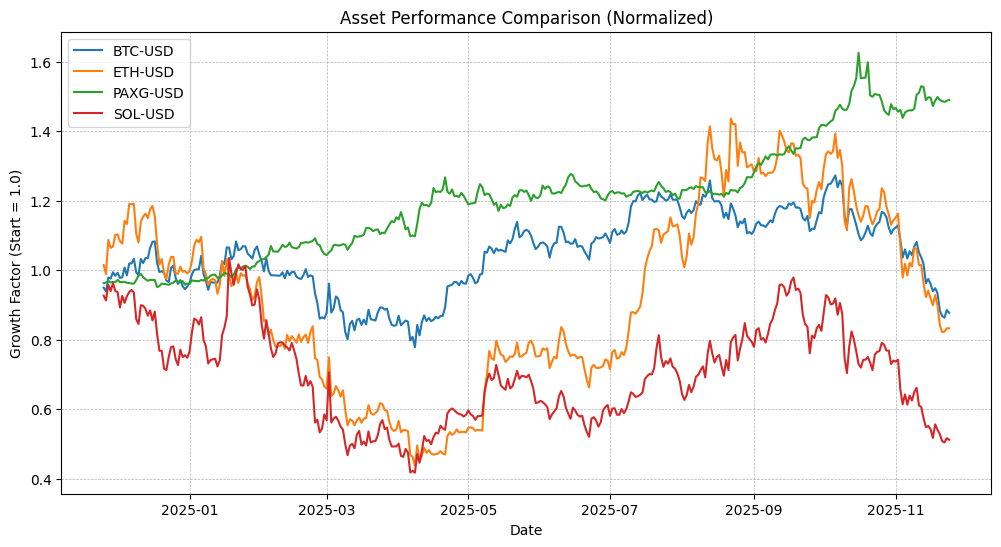

In [9]:
# --- 5. VISUALIZATION (EDA) ---
plt.figure(figsize=(12, 6))

for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Asset Performance Comparison (Normalized)')
plt.xlabel('Date')
plt.ylabel('Growth Factor (Start = 1.0)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
# --- 6. RISK ANALYSIS PREVIEW ---
# Calculate annualized volatility (Standard Deviation * sqrt(365))
# This is a proxy for risk
annual_volatility = daily_returns.std() * np.sqrt(365)
print("\nAnnualized Volatility (Risk):")
print(annual_volatility.sort_values(ascending=False))


Annualized Volatility (Risk):
Ticker
SOL-USD     0.873003
ETH-USD     0.759704
BTC-USD     0.428671
PAXG-USD    0.200792
dtype: float64


In [11]:
# --- 7. PORTFOLIO OPTIMIZATION (MONTE CARLO) ---
# Purpose: Simulate thousands of random portfolio combinations to find the best mix.
num_portfolios = 10000 # Number of simulations
all_weights = np.zeros((num_portfolios, len(tickers)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

In [12]:
# Calculate Mean Daily Returns and Covariance Matrix
mean_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [13]:
# Simulation Loop
for ind in range(num_portfolios):
  # 1. Create Random Weights
  weights = np.array(np.random.random(len(tickers)))
  weights = weights / np.sum(weights)  # Normalize so sum = 1 (100%)
  all_weights[ind, :] = weights

  # 2. Calculate Expected Return (Annualized)
    # Formula: sum(weight * mean_daily_return) * 365
  ret_arr[ind] = np.sum(weights * mean_daily_returns) * 365

  # 3. Calculate Expected Volatility (Risk)
    # Formula: sqrt(transpose(weights) @ (covariance_matrix * 365) @ weights)
    # Algebraically complex, but standard for portfolio variance
  vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 365, weights)))

  # 4. Calculate Sharpe Ratio
    # Sharpe = Return / Volatility (assuming risk-free rate ~ 0 for simplicity)
  sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

print(f"Simulated {num_portfolios} portfolios.")

Simulated 10000 portfolios.


In [14]:
# --- 8. FINDING THE BEST PORTFOLIO ---
# Find the index of the portfolio with the highest Sharpe Ratio
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe_return = ret_arr[max_sharpe_idx]
max_sharpe_vol = vol_arr[max_sharpe_idx]

print("\nBest Portfolio Stats:")
print(f"Return: {max_sharpe_return:.2%}")
print(f"Volatility: {max_sharpe_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}")

print("\nOptimal Allocation:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {all_weights[max_sharpe_idx, i]:.2%}")


Best Portfolio Stats:
Return: 37.20%
Volatility: 19.41%
Sharpe Ratio: 1.92

Optimal Allocation:
BTC-USD: 3.78%
ETH-USD: 3.97%
SOL-USD: 89.81%
PAXG-USD: 2.43%


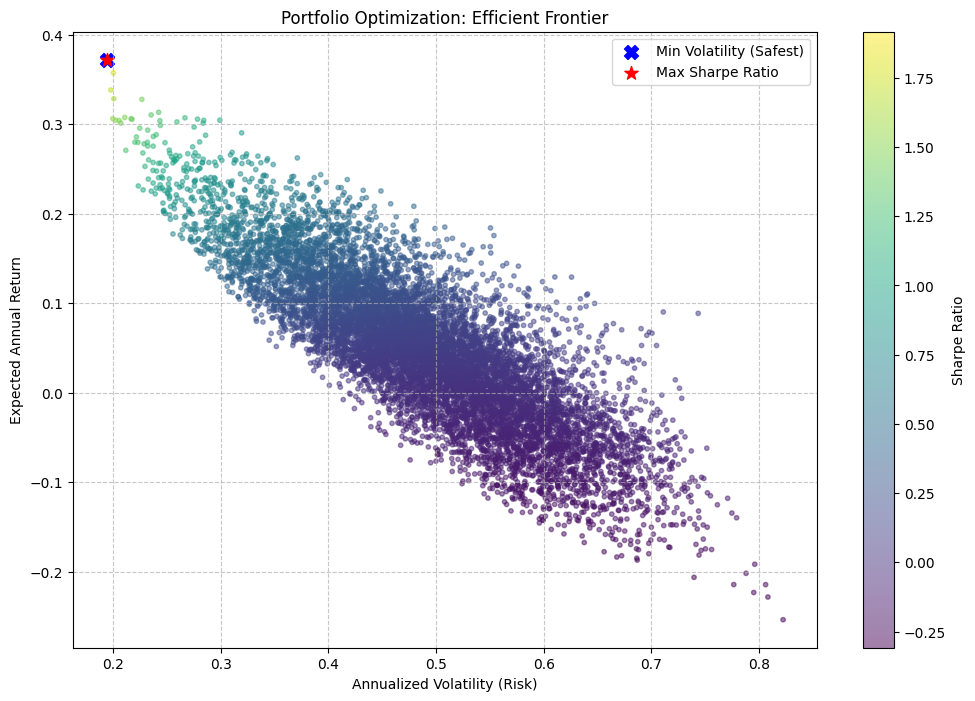

In [15]:
# --- 9. VISUALIZATION: EFFICIENT FRONTIER ---
plt.figure(figsize=(12, 8))

# 1. Plot all generated portfolios
# X-axis = Risk (Volatility), Y-axis = Return
# Color = Sharpe Ratio (lighter is better)
scatter = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Sharpe Ratio')

# 2. Highlight the Safest Portfolio (Min Volatility) - Optional but cool
min_vol_idx = vol_arr.argmin()
plt.scatter(vol_arr[min_vol_idx], ret_arr[min_vol_idx], c='blue', s=100, marker='X', label='Min Volatility (Safest)')

# 3. Highlight the Best Portfolio (Red Star)
plt.scatter(max_sharpe_vol, max_sharpe_return, c='red', s=100, marker='*', label='Max Sharpe Ratio')

# Formatting
plt.title('Portfolio Optimization: Efficient Frontier')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [16]:
# Print stats for the Safest portfolio to compare
print("\nSafest Portfolio (Blue X):")
print(f"Return: {ret_arr[min_vol_idx]:.2%}")
print(f"Volatility: {vol_arr[min_vol_idx]:.2%}")

print("\nOptimal Allocation:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {all_weights[min_vol_idx, i]:.2%}")


Safest Portfolio (Blue X):
Return: 37.20%
Volatility: 19.41%

Optimal Allocation:
BTC-USD: 3.78%
ETH-USD: 3.97%
SOL-USD: 89.81%
PAXG-USD: 2.43%


In [18]:
# Save the optimal weights to a CSV file
optimal_portfolio = pd.DataFrame({
    'Asset': tickers,
    'Weight': all_weights[max_sharpe_idx]
})
optimal_portfolio.to_csv('assets/optimal_portfolio.csv', index=False)